## Inference of Gene Regulatory Network with multi-objective optimisation (OMOPSO)

The problem model is adapted from Khan et. al. doi: 10.1109/TCBB.2019.2892450

The optimization algorithm from Hurtado et. al. doi: 10.1007/s10489-020-01891-1

The python implementation of the jMetal framework from Benitez-Hidalgo et. al. is used: doi: 10.1016/j.swevo.2019.100598 - https://github.com/jMetal/jMetalPy

Experimental Gene Expression data can be downloaded here: http://wws.weizmann.ac.il/mcb/UriAlon/sites/mcb.UriAlon/files/uploads/DownloadableData/sosdata.zip



In [1]:
#import libraries
import numpy as np
import pandas as pd
import csv

from jmetal.algorithm.multiobjective.omopso import OMOPSO
from jmetal.operator import UniformMutation
from jmetal.operator.mutation import NonUniformMutation
from jmetal.util.archive import CrowdingDistanceArchive
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution

import logging

logging.basicConfig(filename='AC_GRN_1.log', level=logging.DEBUG)

In [2]:
#test logging
logging.debug('This message should go to the log file')
logging.info('So should this')
logging.warning('And this, too')
logging.error('And non-ASCII stuff, too, like Øresund and Malmö')

## Load and prepare experimental gene expression data

In [2]:
filepath = "./Data/SOSData/"
filenameActual = "SOSTopology.txt"

df_actualExpression = pd.read_csv(filepath + "Exp1.txt", sep='\t')

# omit first 2 columns of SOS dataset: 1.col = gene name; 2.col = first timepoint with only 0 values
df = df_actualExpression.iloc[:, 2:]
# normalize expression data to range (0,1)
norm_exp = df.apply(lambda x: (x-min(x))/(max(x)-min(x)), axis =1)
'''
NOTE on normalization:
Normalizing expression levels to a range of (0,1) flips the meaning of kinetic orders around:
num in range (0,1) to the power of a negative exponent => 1 < expression level < inf
num in range (0,1) to the power of a positive exponent => 0 < expression level < 1
'''


#Array for Problem Model: indexed by by time points (e.g. array[0] = vector of gene expression for timepoint 0 for all genes)
#convert df to np.array (no headers included) and convert all 0s to 1s (necessary for the problem model, otherwise there would be 0s in the sumprod setting the whole term to zero and throwing an error: NaN value)
actualExpressionTimeInd = np.transpose(norm_exp.to_numpy())
actualExpressionTimeInd[actualExpressionTimeInd == 0] = 1

#Array for Fitness Caluculation: indexed by gene (e.g. array[0] = vector of gene expression of gene 0 for all timepoints) 
#convert df to np.array (no headers included)
actualExpressionGeneInd = norm_exp.to_numpy()


'''
#According to the author of the half-system paper, timepoints & deltas have not been normalized

# normalize timepoints to range(0,1)
def norm_array(arr):
    norm_arr = []
    min_arr = min(arr)
    max_arr = max(arr)
    for i in arr:
        temp = (i - min_arr)/(max_arr - min_arr)
        norm_arr.append(temp)
    return norm_arr

timepoints = norm_array(timepoints)
'''
# extract headers as np.array 
timepoints = np.array(df_actualExpression.columns[2:].astype(int))

## Define Half System Problem Model

Using the jMetal interface

Variable descriptions:

Solution / Variable: List(delta/rate constant, epsilon/degradation term, (error correction term), kinteic order f11 ... f1j, REPEAT for num of genes)

extra_vars = delta/rate constant, epsilon, (my)

=> error correction term/my has not been used


In [51]:
class GRNinfHS(FloatProblem):

    def __init__(self, number_of_genes, extra_vars, timepoints, actualExpressionGeneInd, actualExpressionTimeInd):
        """ :param number_of_variables: Number of decision variables of the problem.
        """
        super(GRNinfHS, self).__init__()
        self.number_of_variables = (number_of_genes * number_of_genes) + extra_vars * number_of_genes
        self.number_of_objectives = 2
        self.number_of_constraints = 0

        self.number_of_genes = number_of_genes
        self.extra_vars = extra_vars

        self.obj_directions = [self.MINIMIZE, self.MINIMIZE]
        self.obj_labels = ['MSE', 'TR']

        # create np array with lower bound for variables
        df_lb = pd.DataFrame(np.zeros((self.number_of_genes,self.number_of_genes + self.extra_vars)))
        df_lb[0] = 0.
        df_lb[1] = 0.
        df_lb[df_lb.columns[self.extra_vars:]] = -3.
        lb = df_lb.to_numpy().ravel()
        
        self.lower_bound = lb #self.number_of_variables * [0.0]
        
        # create np array with upper bound for variables
        df_ub = pd.DataFrame(np.zeros((self.number_of_genes,self.number_of_genes + self.extra_vars)))
        df_ub[0] = 2.
        df_ub[1] = 2.
        df_ub[df_ub.columns[self.extra_vars:]] = 3.
        ub = df_ub.to_numpy().ravel()
        
        self.upper_bound = ub #self.number_of_variables * [1.0]

        self.timepoints = timepoints
        self.actualExpressionGeneInd = actualExpressionGeneInd
        self.actualExpressionTimeInd = actualExpressionTimeInd

    #Caluclate Fitness
    def evaluate(self, solution: FloatSolution) -> FloatSolution:

        #transform solution variables from 1d list to 2d np.array. e.g. arr_solution[0] should give all variables for gene 0
        arr_solution = np.array(solution.variables)
        arr_solution.shape = (self.number_of_genes, -1)

        MSE = 0
        TR = 0

        for gene in range(0,self.number_of_genes):
            
            ts_pred = self.timeSeriesPrediction(arr_solution, gene)
            MSE = MSE + self.calculateMSE(ts_pred, gene)
            TR = TR + self.calculateTR(arr_solution, gene)

        #caluclate the mean over all genes
        MSE = MSE/self.number_of_genes

        solution.objectives[0] = MSE
        solution.objectives[1] = TR

        return solution



    #calculate predicted gene expression levels for one gene at all timepoints
    def timeSeriesPrediction(self, arr_solution, gene):

        #array to store time series gene expression predictions for one gene
        predExpression = np.empty(len(self.timepoints))
        predExpression[0] = 0

        for t in range(1,len(timepoints)):
            timediff = self.timepoints[t] - self.timepoints[t-1]
            #calculate predicted gene expression for one gene at one timepoint
            pred = timediff * (arr_solution[gene][0] * np.prod(np.power(self.actualExpressionTimeInd[t-1], arr_solution[gene][self.extra_vars:]))) + (1 - timediff * arr_solution[gene][1]) * predExpression[t-1] 
            
            predExpression[t] = pred
            '''
            if pred <= 0:
                predExpression[t] = 0
            else:
                predExpression[t] = pred
            '''
            '''
            error correction term:
             + arr_solution[gene][2] * (predExpression[t-1] - self.actualExpressionTimeInd[gene][t-1])
            according to the author of the half-system paper, further research did not indicate that the error correction term provides any benefit and is omitted here as well
            ''' 
        return predExpression


    #calculate MSE for one gene for timeseries
    def calculateMSE(self, predExpression, gene):
        #version1
        MSE = sum(np.power(self.actualExpressionGeneInd[gene] - predExpression,2))/len(predExpression)
        
        #version2
        #MSE = sum(np.power((predExpression - self.actualExpressionTimeInd[gene])/self.actualExpressionTimeInd[gene], 2))
       
        return MSE


    #calculate TR for kinteic orders (not extra_vars: rate constant and degradation term) for one gene for timeseries
    def calculateTR(self, arr_solution, gene, cardinality = 4):
        sortedSol = np.sort(np.abs(arr_solution[gene][self.extra_vars:]))
        extract = sortedSol[:(self.number_of_genes-cardinality)]
        return sum(extract)

    def get_name(self):
        return 'GRNinfHS'

## Define S-System Problem Model

Using the jMetal interface

Variable descriptions:

Solution / Variable: List(alpha/rate constant production, alpha/rate constant degradation, kinteic order g11 ... g1j for production, kinteic order h11 ... h1j for degradation, REPEAT for num of genes)

extra_vars = delta/rate constant, epsilon, (my)

In [4]:
class GRNinfSS(FloatProblem):

    def __init__(self, number_of_genes, extra_vars, timepoints, actualExpressionGeneInd, actualExpressionTimeInd, eta):
        """ :param number_of_variables: Number of decision variables of the problem.
        """
        super(GRNinfSS, self).__init__()
        self.number_of_variables = (2 * number_of_genes * number_of_genes) + extra_vars * number_of_genes
        self.number_of_objectives = 2
        self.number_of_constraints = 0

        self.number_of_genes = number_of_genes
        self.extra_vars = extra_vars

        self.obj_directions = [self.MINIMIZE, self.MINIMIZE]
        self.obj_labels = ['MSE', 'TR']

        # create np array with lower bound for variables
        df_lb = pd.DataFrame(np.zeros((self.number_of_genes,2*self.number_of_genes + self.extra_vars)))
        df_lb[0] = 0.
        df_lb[1] = 0.
        df_lb[df_lb.columns[self.extra_vars:]] = -3.
        lb = df_lb.to_numpy().ravel()
        
        self.lower_bound = lb #self.number_of_variables * [0.0]
        
        # create np array with upper bound for variables
        df_ub = pd.DataFrame(np.zeros((self.number_of_genes,2*self.number_of_genes + self.extra_vars)))
        df_ub[0] = 10.
        df_ub[1] = 10.
        df_ub[df_ub.columns[self.extra_vars:]] = 3.
        ub = df_ub.to_numpy().ravel()
        
        self.upper_bound = ub #self.number_of_variables * [1.0]

        self.timepoints = timepoints
        self.actualExpressionGeneInd = actualExpressionGeneInd
        self.actualExpressionTimeInd = actualExpressionTimeInd
        self.eta = eta

    #Caluclate Fitness
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        #transform solution variables from 1d list to 2d np.array. e.g. arr_solution[0] should give all variables for gene 0
        arr_solution = np.array(solution.variables)
        arr_solution.shape = (self.number_of_genes, -1)

        #initialize ones array for preditcions
        predictions = np.ones(np.shape(self.actualExpressionTimeInd))

        actExp = self.actualExpressionTimeInd

        # calculate prediced gene expression for all genes at timepoint t
        for t in range(1,len(timepoints)): 

            for gene in range(0,self.number_of_genes):
                pred = predictions[t-1][gene] + 0.5 * self.eta * (self.SScalc(actExp, arr_solution, t, gene, "ACTUAL") + self.SScalc(predictions, arr_solution, t-1, gene, "PREDICTION"))
                
                if pred <= 0:
                    predictions[t][gene] = 1
                else:
                    predictions[t][gene] = pred
                
                #logging.debug("Timepoint %s and gene %s", t, gene)
                #logging.debug(predictions[t][gene])

        # claculate MSE
        MSE = sum(sum(np.power((predictions - self.actualExpressionTimeInd)/self.actualExpressionTimeInd, 2)))

        # claculate TR
        TR = 0
        
        for gene in range(0,self.number_of_genes):
            sortedSol = np.sort(np.abs(arr_solution[gene][self.extra_vars:]))
            extract = sortedSol[:(self.number_of_genes*2-4)]
            TR = TR + sum(extract)

        solution.objectives[0] = MSE
        solution.objectives[1] = TR   

        return solution

    # calculate SS for one gene at one timepoint
    def SScalc(self, expression, arr_solution, t, gene, exptype):  
        result = arr_solution[gene][0] * np.prod(np.power(expression[t], arr_solution[gene][self.extra_vars : self.extra_vars + self.number_of_genes])) - arr_solution[gene][1] * np.prod(np.power(expression[t], arr_solution[gene][self.extra_vars + self.number_of_genes : ]))
        
        '''
        if exptype == "PREDICTION":
            logging.debug("Predicion SS result %s", result)
            logging.debug("Expression Array %s", expression[t])
            logging.debug("Solution Array Production %s", arr_solution[gene][self.extra_vars : self.extra_vars + self.number_of_genes]) 
            logging.debug("Solution Array Degradation %s", arr_solution[gene][self.extra_vars + self.number_of_genes : ])   
        if exptype == "ACTUAL":
            logging.debug("Actual SS result %s", result)   
        '''

        return result

    def get_name(self):
        return 'GRNinfSS'

## Execute the Optimization

Using the defined Problem Model with the jMetal OMOPSO algorithm

In [52]:
problem = GRNinfHS(number_of_genes = 8, extra_vars = 2, timepoints = timepoints, actualExpressionGeneInd = actualExpressionGeneInd, actualExpressionTimeInd = actualExpressionTimeInd) #, eta = 0.00000000001

max_evaluations = 5000
swarm_size = 100
mutation_probability = (swarm_size / 3) / 100

algorithm = OMOPSO(
    problem=problem,
    swarm_size=swarm_size,
    epsilon=0.0075,
    uniform_mutation=UniformMutation(probability=mutation_probability, perturbation=0.5),
    non_uniform_mutation=NonUniformMutation(mutation_probability, perturbation=0.5,
                                            max_iterations=int(max_evaluations / swarm_size)),
    leaders=CrowdingDistanceArchive(100),
    termination_criterion=StoppingByEvaluations(max_evaluations)
)

algorithm.run()
solutions = algorithm.get_result()

## Visualize the Pareto Front

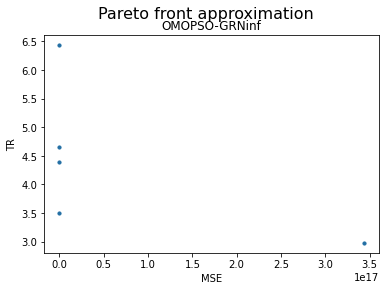

In [53]:
from jmetal.lab.visualization.plotting import Plot
from jmetal.util.solution import get_non_dominated_solutions

front = get_non_dominated_solutions(solutions)

plot_front = Plot(title='Pareto front approximation', axis_labels=['MSE', 'TR'])
plot_front.plot(front, label='OMOPSO-GRNinf')

In [54]:
#print fitness values of non-dominated solutions in the pareto front 

for sol in front:
    print(sol.objectives)

[5940291.54619306, 6.43197708207405]
[6980903.24727929, 4.6578597740054475]
[9679869.529901542, 4.398570481075626]
[3.4330852009741594e+17, 2.9796441082456893]
[178846123.85248303, 3.5043809326920172]


## Calculating Performance

Using confusion matrix metrics

In [55]:
#Functions for calculating confusion matrix results

# solution / predicted data preparation for confusion matrix calcs
def prepareSolution(solutions, sol):
    solprep = np.array(solutions[sol].variables[:])
    solprep.shape = (8,-1)
    solprep = pd.DataFrame(solprep)
    # drop first 3 columns = extra variables
    solprep = solprep.drop(solprep.columns[[0,1]], axis =1)
    # widen to 1d np array
    solprep = solprep.values.reshape(1,-1)
    solprep = solprep.ravel()
    
    '''
    Take the mean of the absolute values of the kinetic order
    Everything below the negative mean and above the positive mean is set to 1, indicating a valid interaction
    Everything else is set to 0, indicating no edge in the network
    '''
    abs_sols = np.absolute(solprep)
    mean_sols = abs_sols.mean()
    std_sols = abs_sols.std()

    solprep[solprep <= -(mean_sols)] = 1
    solprep[solprep >= mean_sols] = 1
    solprep[solprep != 1] = 0

    '''
    # replace all non-zero values with 1 (indicating that there is an edge between nodes)
    solprep[solprep != 0.] = 1
    solprep = solprep.astype(int)
    '''

    '''
    Set one variable to 0 to be able to caculate confusion matrix. Only necessary because algorithm doesnt succeed yet to set variables to 0.
    Otherwise there would not be a "non existing edge" in the gene network graph. All nodes would be connected.  
    The majority of variables should be zero => no existing edges
    '''
    #solprep[0] = 0
    
    
    print(solprep)
    return solprep

# actual data preparation for confusion matrix calcs
def prepareActual(filepath, filename):
    # read in actual SOS topology
    actual = pd.read_csv(filepath + filename, sep='\t')
    # drop first column (gene names)
    actual = actual.iloc[: , 1:]
    # widen to 1d np array
    actual = actual.values.reshape(1,-1)
    actual = actual.ravel()

    # replace all non-zero values with 1 (indicating that there is an edge between nodes)
    actual[actual != 0] = 1
    
    print(actual)
    return actual

# calculate confustion matrix results
def calculateConMatResults(solutions, solnum, filepath, filename):
    predicted = prepareSolution(solutions, solnum)
    actual = prepareActual(filepath, filename)

    # create df
    d = {"actual":actual, "predicted":predicted}
    df_confmat = pd.DataFrame(data=d)
    confmat = pd.crosstab(df_confmat['actual'], df_confmat['predicted'], rownames=['Actual'], colnames=['Predicted'])

    print(df_confmat)
    print(confmat)

    TP = confmat.iloc[1,1]
    FP = confmat.iloc[0,1]
    TN = confmat.iloc[0,0]
    FN = confmat.iloc[1,0]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    PPV = TP/(TP+FP)
    ACC = (TP+TN)/(TP+FP+FN+TN)
    Fscore = (2*TP)/(2*TP+FP+FN)

    d = {"TP":TP, "FP":FP, "TN":TN, "FN":FN, "TPR":TPR, "FPR":FPR, "TNR":TNR, "PPV":PPV, "ACC":ACC, "Fscore":Fscore}

    return d
    
out = calculateConMatResults(front, 0, filepath, filenameActual)
out

[0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
    actual  predicted
0        0        0.0
1        1        0.0
2        0        1.0
3        0        1.0
4        0        0.0
..     ...        ...
59       0        0.0
60       0        0.0
61       0        0.0
62       0        0.0
63       0        0.0

[64 rows x 2 columns]
Predicted  0.0  1.0
Actual             
0           35   20
1            6    3


{'TP': 3,
 'FP': 20,
 'TN': 35,
 'FN': 6,
 'TPR': 0.3333333333333333,
 'FPR': 0.36363636363636365,
 'TNR': 0.6363636363636364,
 'PPV': 0.13043478260869565,
 'ACC': 0.59375,
 'Fscore': 0.1875}

## Result Analysis

It is quite obvious from the pareto front that:

a) some of the MSE values dont make sense with this magintude. It is expected to converge towards 0

b) the topology regulation (TR) fitness value is generally much to high given that we expect most of the summed parameters (kinteic orders) to be 0. In Hurtado et. al the TR value typically was <0.5


### Explore predicted paramters (kinteic orders)

Bsed on predicted variables, compute predicted gene expression levels and MSEs for each gene.


In [8]:
import matplotlib.pyplot as plt


# function to explore variables for one gene in a given solution from the front

def explore_params(sol_num, front, gene, timepoints, actualExpressionGeneInd, actualExpressionTimeInd):
    # extract the variables for the first non-doinated solution in the pareto front
    arr = np.array(front[sol_num].variables[:])
    arr.shape = (8,-1)
    df = pd.DataFrame(arr)
    var_arr = df.iloc[gene,:].to_numpy().ravel()

    # using the paramters, calculate predicted gene expression levels
    predExpression = np.empty(len(timepoints))
    predExpression[0] = 0

    for t in range(1,len(timepoints)):
                timediff = timepoints[t] - timepoints[t-1]
                #calculate predicted gene expression for one gene at one timepoint
                predExpression[t] = timediff * (var_arr[0] * np.prod(np.power(actualExpressionTimeInd[t-1], var_arr[2:]))) + (1 - timediff * var_arr[1]) * predExpression[t-1]

    #predExpression
    MSE = sum(np.power(actualExpressionGeneInd[gene] - predExpression,2))/len(predExpression)

    return MSE, predExpression



### Explore paramaters for all genes in a given solution

In [25]:
# Empty list to store results
r_params = []
for i in range(0,len(actualExpressionGeneInd)):
    x=[]
    for j in range(0,2):
        x.append(0)
    r_params.append(x)


for gene in range(0, len(actualExpressionGeneInd)):
    #Enter solution number you want to explore:
    sol_num = 1
    MSE, predExpression = explore_params(sol_num, front, gene, timepoints, actualExpressionGeneInd, actualExpressionTimeInd)
    r_params[gene][0] = MSE
    r_params[gene][1] = predExpression

### Visulaize predicted gene expression values and MSEs for all genes in a given solution

 ==> MSE: 0.093


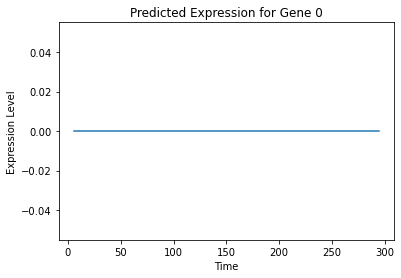

 ==> MSE: 0.098


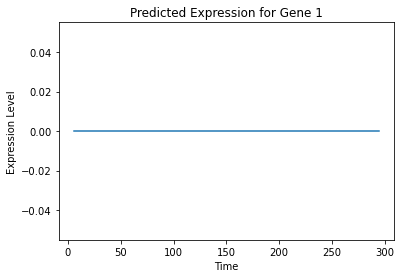

 ==> MSE: 0.199


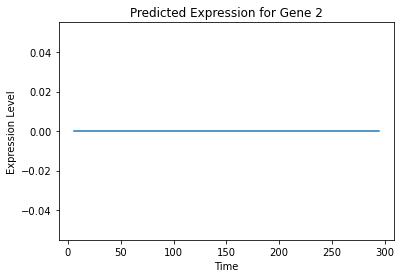

 ==> MSE: 39121635119975229681392654202836646765244802658874701580861440.000


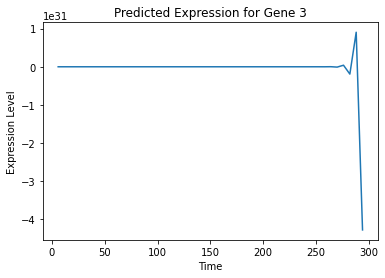

 ==> MSE: 101824867299613407090347648263013546999371649934430306304.000


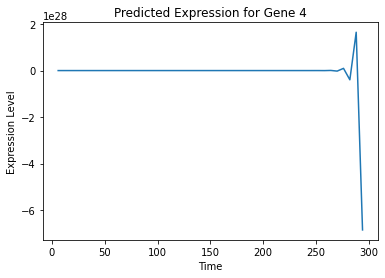

 ==> MSE: 75301207719378145462359013433582240634227538094538879162908672.000


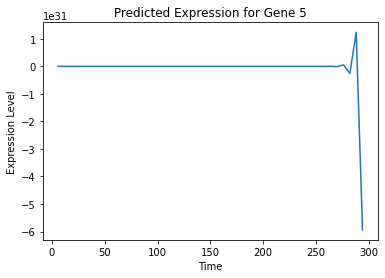

 ==> MSE: 0.455


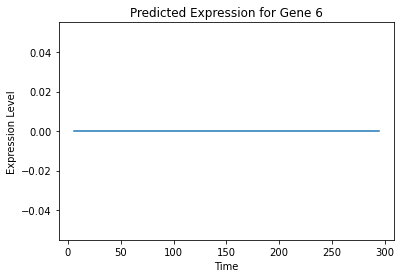

 ==> MSE: 1202503468283775029997062951575990249542303280085125480411299840.000


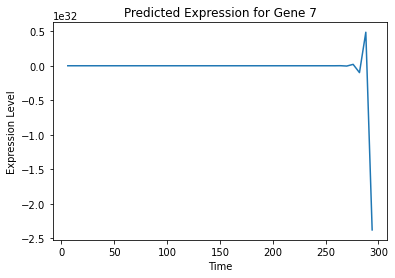

In [26]:
for gene in range(0, len(actualExpressionGeneInd)):
    print(" ==> MSE: %.3f" % r_params[gene][0])
    plt.plot(timepoints, r_params[gene][1])
    plt.title('Predicted Expression for Gene '+ str(gene))
    plt.xlabel('Time')
    plt.ylabel('Expression Level')
    plt.show()


## Observation:

Expression values sometimes have extreme swings and take on very large numbers ==> should not be as the experimental expression values are normalized between 0 and 1. Predicted values should be in the same range

Gene expression levels sometimes alternate between positive and negative values ==> Genes cannot have a negative expression level.

Negative gene expression values need to come from the degradation term "(1 - timediff * arr_solution[gene][1]) * predExpression[t-1]" in the half system. With the timediff greater 0, the rate constant lower bound by 0, the actual gene expression between 0 and 1, raised to the kinteic order betweem -2 and 2, this term cannot become negative on its own.

The degradation term is largely influenced by the prediced expression (predExpression[t-1]), which in turn is influenced by the kinteic orders. Consequently, a fine balance between all variables need to be found as previous predicted results (t-1) and actual expression values are influencing current results. For Gene 0 and 3 in particular one can see how the predicted expression level gets out of balance. Expression levels start swingin slowly and get very big very quickly.

The problem with the OMOPSO algorithm in jMetal is that the objective funcations (MSE and TR) are calculated over all timeseries predictions and all genes together. This likely makes it difficult to find a delicate balance of variables for one gene to predict its timeseries alone. A better result might be obtained when optimising the MSE and TR for each gene and its timeseries predictions separately from the other genes, as is done in Khan et. al.

This optimization across the enitre variable space simulatneously might also be the reason why the topology regulatiration (TR) fails to set kinetic orders to 0.

The OMOPSO algorithm did run for 100,000 iterations as described in Hurtado et. al. The algorithm in Khan et. al already produced sensible results after 5000 iterations as descrbed in the paper. Although non-existing edges have been identified and the kinteic orders set to zero based on an arbitrary threshold. The OMOSPO algorithm on the other hand tries to rely on the TR to set kinetic orders to zero and thus remove edges from the network.